# uci_nn_models.ipynb
The purpose of this file is to a neural network model based on the pki dataset. Since the pki dataset is imbalanced, upsampling will be performed frist followed by the model training 

## Upsampling the data

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

uci_df = pd.read_csv("../MLP2/input/heart_disease_uci_normalized.csv")
X = np.c_[uci_df.drop("num", axis = 1)]
y = np.c_[uci_df["num"]]

target_names = ['No Heart Disease', 'Has Heart Disease']

print("X shape: ", X.shape)
print("y shape: ", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print("X_train shape: ", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", y_test.shape)

X shape:  (920, 33)
y shape:  (920, 1)
X_train shape:  (644, 33)
X_test shape:  (276, 33)
y_train shape:  (644, 1)
y_test shape:  (276, 1)


d_X shape:  (410, 33)
d_y shape:  (410, 1)

X_train shape:  (287, 33)
X_test shape:  (123, 33)
y_train shape:  (287, 1)
y_test shape:  (123, 1)


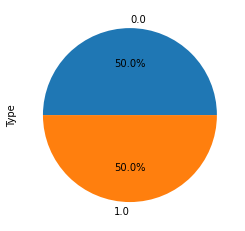

In [4]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

uci_df = pd.read_csv("../MLP2/input/heart_disease_uci_normalized.csv")
x_columns = uci_df.columns.drop(["num"])
y_columns = ['num']
target_names = ['No Heart Disease', 'Has Heart Disease']

positive_df = uci_df[uci_df['num'] == 1]
negative_df = uci_df[uci_df['num'] == 0]

tmp = resample(negative_df, replace=True, n_samples=int(len(negative_df) / 2), random_state=42)
upsample = resample(positive_df, replace=True, n_samples=len(tmp), random_state=42)
upsampled_df = pd.concat([tmp, upsample])
upsampled_df.groupby('num').size().plot(kind='pie', y='HeartDisease', label='Type', autopct='%1.1f%%')

u_X = np.c_[upsampled_df[x_columns]]
u_y = np.c_[upsampled_df[y_columns]]

print("d_X shape: ", u_X.shape)
print("d_y shape: ", u_y.shape)

uX_train, uX_test, uy_train, uy_test = train_test_split(u_X, u_y, test_size=0.3, random_state=42)
print("\nX_train shape: ", uX_train.shape)
print("X_test shape: ", uX_test.shape)
print("y_train shape: ", uy_train.shape)
print("y_test shape: ", uy_test.shape)

## Training the MLP Classifier

In [7]:
from dataclasses import dataclass

@dataclass
class MetricContainer:
    name: str
    precision: float = 0
    recall: float = 0
    f1_score: float = 0

def average_classification_report(arr: list):
    no_hd = MetricContainer('No Heart Disease')
    has_hd = MetricContainer('Has Heart Disease')

    for elem in arr:
        no_hd.precision += elem['No Heart Disease']['precision']
        no_hd.recall += elem['No Heart Disease']['recall']
        no_hd.f1_score += elem['No Heart Disease']['f1-score']

        has_hd.precision += elem['Has Heart Disease']['precision']
        has_hd.recall += elem['Has Heart Disease']['recall']
        has_hd.f1_score += elem['Has Heart Disease']['f1-score']   

    size = len(arr)
    no_hd.precision /= size
    no_hd.recall /= size
    no_hd.f1_score /= size

    has_hd.precision /= size
    has_hd.recall /= size
    has_hd.f1_score /= size

    print(no_hd)
    print(has_hd)

    return has_hd.recall
    
def find_optimal_value(values: list, report: list) -> int:
    optimal_value = values[0]
    recall = report[0]

    for idx, val in enumerate(values[0:]):
        if (report[idx] > recall):
            optimal_value = val
            recall = report[idx]
    return optimal_value

In [8]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=10, random_state=None, shuffle=True)

# Find optimal iterations

In [15]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

iter_values = [100, 500, 1000]
iter_report = []

for iter in iter_values:
    clf = MLPClassifier(max_iter=iter, random_state=42)
    report = []
    for train_id, test_id in kf.split(X_train):
        
        X_train_kf, X_test_kf = X_train[train_id], X_train[test_id]
        y_train_kf, y_test_kf = y_train[train_id], y_train[test_id]

        clf.fit(X_train_kf, y_train_kf.ravel())

        y_pred = clf.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_MLP = find_optimal_value(iter_values, iter_report)
print(optimal_iter_MLP)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Average report at iter =  100
MetricContainer(name='No Heart Disease', precision=0.8167433533466694, recall=0.7992147062420465, f1_score=0.8041206716716912)
MetricContainer(name='Has Heart Disease', precision=0.8438433740076239, recall=0.8665338938965942, f1_score=0.8522941307669651)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

Average report at iter =  500
MetricContainer(name='No Heart Disease', precision=0.7833882409444628, recall=0.7844688720683944, f1_score=0.7799532535954544)
MetricContainer(name='Has Heart Disease', precision=0.8301056044958484, recall=0.8304289438112967, f1_score=0.8275713849035702)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the 

Average report at iter =  1000
MetricContainer(name='No Heart Disease', precision=0.7792308788346778, recall=0.7628880617590295, f1_score=0.7680420042207696)
MetricContainer(name='Has Heart Disease', precision=0.8205717039772766, recall=0.8336927835921644, f1_score=0.8252938640075778)
100


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


# Find optimal layers

In [29]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

iter_values = [(100), (100, 100,), (100, 100, 100,), (100, 100, 100, 100,)]
iter_report = []

for iter in iter_values:
    clf = MLPClassifier(max_iter=100, random_state=42, hidden_layer_sizes=iter)
    report = []
    for train_id, test_id in kf.split(X_train):
        
        X_train_kf, X_test_kf = X_train[train_id], X_train[test_id]
        y_train_kf, y_test_kf = y_train[train_id], y_train[test_id]

        clf.fit(X_train_kf, y_train_kf.ravel())

        y_pred = clf.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_MLP = find_optimal_value(iter_values, iter_report)
print(optimal_iter_MLP)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Average report at iter =  100
MetricContainer(name='No Heart Disease', precision=0.820324001470928, recall=0.7968791110481052, f1_score=0.8061380061469589)
MetricContainer(name='Has Heart Disease', precision=0.8441521316842241, recall=0.8594525161243428, f1_score=0.8504216997944525)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Average report at iter =  (100, 100)
MetricContainer(name='No Heart Disease', precision=0.7926352142995636, recall=0.762291606448685, f1_score=0.7753985358192033)
MetricContainer(name='Has Heart Disease', precision=0.8230448160174785, recall=0.8431768170583961, f1_score=0.8321421361189298)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Average report at iter =  (100, 100, 100)
MetricContainer(name='No Heart Disease', precision=0.7702033460169649, recall=0.7721688466849759, f1_score=0.7685209713793144)
MetricContainer(name='Has Heart Disease', precision=0.8289537482803455, recall=0.82460688953336, f1_score=0.8246762852999291)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Average report at iter =  (100, 100, 100, 100)
MetricContainer(name='No Heart Disease', precision=0.7749868432221373, recall=0.7730878431912915, f1_score=0.7708902342081005)
MetricContainer(name='Has Heart Disease', precision=0.8283703064929069, recall=0.8223760542011815, f1_score=0.8231591993864725)
100


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


optimal is 1 layer of hidden nodes

# Find optimal number of units

In [30]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

iter_values = [20, 50, 100, 150, 200]
iter_report = []

for iter in iter_values:
    clf = MLPClassifier(max_iter=100, random_state=42, hidden_layer_sizes=(iter) )
    report = []
    for train_id, test_id in kf.split(X_train):
        
        X_train_kf, X_test_kf = X_train[train_id], X_train[test_id]
        y_train_kf, y_test_kf = y_train[train_id], y_train[test_id]

        clf.fit(X_train_kf, y_train_kf.ravel())

        y_pred = clf.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_MLP = find_optimal_value(iter_values, iter_report)
print(optimal_iter_MLP)

c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Average report at iter =  20
MetricContainer(name='No Heart Disease', precision=0.8127490079261068, recall=0.787909266865051, f1_score=0.7974151897189816)
MetricContainer(name='Has Heart Disease', precision=0.8400082455899727, recall=0.8558288854980031, f1_score=0.8459603568335856)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Average report at iter =  50
MetricContainer(name='No Heart Disease', precision=0.8222927986061185, recall=0.7920123636920077, f1_score=0.8053948695255061)
MetricContainer(name='Has Heart Disease', precision=0.8473658137072771, recall=0.8672002471238466, f1_score=0.8564290376358228)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Average report at iter =  100
MetricContainer(name='No Heart Disease', precision=0.8121513537586045, recall=0.8130956564137877, f1_score=0.8085301455788703)
MetricContainer(name='Has Heart Disease', precision=0.8564793132700235, recall=0.8563361041411646, f1_score=0.8537666775894712)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Average report at iter =  150
MetricContainer(name='No Heart Disease', precision=0.8194840647343428, recall=0.8134566696744117, f1_score=0.8114787027510865)
MetricContainer(name='Has Heart Disease', precision=0.8533268897485184, recall=0.8617138436713006, f1_score=0.8547638686687229)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

Average report at iter =  200
MetricContainer(name='No Heart Disease', precision=0.8131386559890272, recall=0.8136741551459293, f1_score=0.8081743736097909)
MetricContainer(name='Has Heart Disease', precision=0.8548446015006803, recall=0.8592324826336455, f1_score=0.8542701143614009)
50


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


optimal is 50

# Run NN with optimal parameters and save report

In [32]:
clf = MLPClassifier(max_iter=100, random_state=42, hidden_layer_sizes=(50))
clf.fit(X_train, y_train.ravel())
y_pred = clf.predict(X_test)
confusion_mat = confusion_matrix(y_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(y_test, y_pred, target_names=target_names))

class_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)

class_df = pd.DataFrame(class_report).transpose()
class_df.to_csv('./NN_results/uci_nn_classification_report_test.csv')

[[127  19]
 [ 31  99]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.84      0.76      0.80       130
Has Heart Disease       0.80      0.87      0.84       146

         accuracy                           0.82       276
        macro avg       0.82      0.82      0.82       276
     weighted avg       0.82      0.82      0.82       276



c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy =  0.8934668071654372


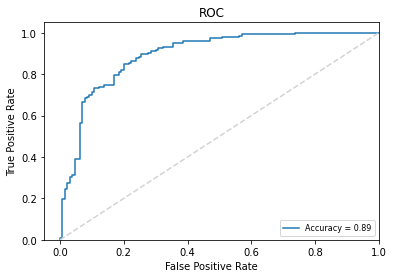

In [37]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = clf.predict_proba(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_score[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)

print('Accuracy = ', roc_auc)

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("./NN_results/uci_nn_roc_test.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

In [38]:
train_sizes = np.linspace(0.2, 0.8, 50)

train_sizes, train_mse, test_mse = learning_curve(clf, X, y.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='accuracy', 
                                    cv=3, shuffle=True)

train_scores = train_mse
test_scores = test_mse

#print(train_scores)
#print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('A learning curve for logistic regression')
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.savefig("./NN_results/uci_nn_learning_curve.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti